# Lab 1 - wyrażenia regularne

Treść zadań dostępna [tutaj](README.md), a w oryginale na https://github.com/apohllo/pjn/blob/master/1-regexp.md

**Wykonanie zadań**: Marcin Przewięźlikowski

https://github.com/mprzewie/nlp_course

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import regex 
from pprint import pprint

# Regular expressions (aka regexps)

## Task

A dataset containing texts of Polish statutory law is available at [http://apohllo.pl/text/ustawy.tar.gz](http://apohllo.pl/text/ustawy.tar.gz).

It contains texts of Polish bills, e.g.:

```
Tekst ustawy przyjęty przez Senat bez poprawek
 
USTAWA
z
dnia 8 listopada 2013 r.
 
o
zmianie niektórych ustaw w związku z realizacją ustawy budżetowej[1])
 
Art.
1. 
W
ustawie z dnia 4 marca 1994 r. o zakładowym funduszu świadczeń socjalnych (Dz. U.
z 2012 r. poz. 592, z późn. zm.[2]))
po art. 5b dodaje się art. 5c w brzmieniu:
„Art. 5c. W 2014 r. przez
przeciętne wynagrodzenie miesięczne w gospodarce narodowej, o którym mowa w art.
5 ust. 2, należy rozumieć przeciętne wynagrodzenie miesięczne w gospodarce narodowej
w drugim półroczu 2010 r. ogłoszone przez Prezesa Głównego Urzędu Statystycznego
na podstawie art. 5 ust. 7.”.
```

The task is to:

Find all external references to bills, e.g. **ustawie z dnia 
   4 marca 1994 r. o zakładowym funduszu świadczeń socjalnych (Dz. U.  z 2012 r. poz. 592)**.
   The result should be aggregated by bill ID (year and position) and sorted by descending number of reference
   counts. The reference format should include:
   * the title of the regulation (if present)
   * the year of the regulation
   * the number of the Journal of Laws of the Republic of Poland (*Dziennik Ustaw*) - if applicable
   * the position of the regulation
   

In [84]:
regexp1_1 = "Dz[.]\s*U[.]" \
"(((\s*z\s*\d{4}\s*r[.])?\s*(Nr\s*(\d+),\s*poz[.]\s*(\d+))\s*(,|i|oraz)?)+)" \

regexp1_2 = "(z\s*(\d{4})\s*r[.]\s*((Nr\s*\d+\s*,\s*poz[.]\s*\d+\s*(,|i)?\s*)+))"

regexp1_3 = "Nr\s*(\d+)\s*,\s*poz[.]\s*(\d+)"

In [85]:
def get_references(text):
    result = []
    journal_references = [jr[0] for jr in regex.findall(regexp1_1, text)]
    for jr in journal_references:
        years_refs = regex.findall(regexp1_2, jr)
        for yr in years_refs:
            year = yr[1]
            refs = regex.findall(regexp1_3, yr[2])
            result.extend([(year, *ref) for ref in refs])
    return result

In [86]:
p = Path("../data")

files = [f for f in p.rglob("**/*") if f.is_file()]

references = []

for file in files:
    year, nr =  regex.findall("(\d{4})_(\d+)",str(file))[0]
    with file.open() as f:
        text = f.read()
        text = regex.sub("Dz[.]\s*U[.]\s*Nr", f"Dz. U. z {year} r. Nr", text)
        references.extend(get_references(text))

In [87]:
refs_and_counts = [
    (ref, references.count(ref))
    for ref in set(references)
]

In [88]:
sorted(refs_and_counts, key=lambda rc: -rc[1])

[(('1998', '106', '668'), 669),
 (('1996', '106', '496'), 474),
 (('1997', '121', '770'), 352),
 (('2000', '12', '136'), 299),
 (('1997', '88', '554'), 297),
 (('1997', '28', '153'), 248),
 (('1990', '34', '198'), 203),
 (('2000', '120', '1268'), 200),
 (('1992', '54', '254'), 144),
 (('1998', '162', '1118'), 144),
 (('1997', '141', '943'), 134),
 (('1997', '43', '272'), 132),
 (('1989', '35', '192'), 132),
 (('2006', '104', '708'), 131),
 (('1995', '4', '17'), 130),
 (('2000', '48', '550'), 122),
 (('1994', '121', '591'), 122),
 (('1995', '34', '163'), 118),
 (('1994', '1', '3'), 115),
 (('1998', '117', '756'), 114),
 (('1994', '27', '96'), 107),
 (('1996', '24', '110'), 103),
 (('1997', '106', '679'), 103),
 (('1994', '43', '163'), 102),
 (('1999', '70', '778'), 101),
 (('2002', '153', '1271'), 98),
 (('1999', '110', '1255'), 96),
 (('1999', '83', '931'), 96),
 (('1993', '134', '646'), 95),
 (('1997', '121', '769'), 95),
 (('2002', '74', '676'), 93),
 (('1994', '105', '509'), 91),
 (

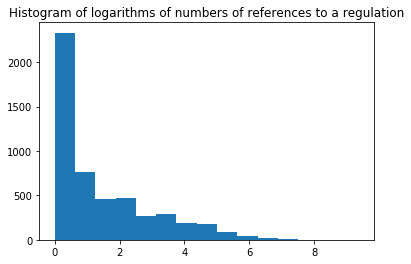

In [89]:
plt.hist([np.log2(rc[1]) for rc in refs_and_counts], bins=15)
plt.title("Histogram of logarithms of numbers of references to a regulation")
plt.show()

Find all internal references to regulations, e.g.  **art.  5 ust. 2**, **art. 5 ust. 7**, etc. The result should
   exclude the internal numbering of the bill (e.g. **Art. 1.** W ustawie ...).
   The result should be aggregated by regulation ID (as described below) and sorted by descending number of reference
   counts inside particular bill. The bills should be sorted by descending number of internal references. 
   The reference format should include all elements necessary to identify the regulation, e.g.:
   * art. 1, ust. 2 - if an article inside the regulation is referenced,
   * ust. 2 - if a paragraph inside the same article is referenced,
   * etc.
   

In [263]:
regexp2_1 = "brzmieni[e|u|a]:\s*.\s*[^”]*”"
regexp2_2 = "(?<!brzmieni[e|u|a]:\s*.\s*)Art[.]\s*(\d+)"
regexp2_3 = "art[.]\s*(\d+)\s*,\s*ust[.]\s*(\d+)"

In [272]:
def get_internal_references(text):
#     text = regex.sub(regexp2_1, "brzmienie:(...)", text)
    return text
#     articles_matches = regex.finditer(regexp2_1, text)
#     return articles_matches
# #     print(articles_matches)
# #     articles_matches = ["0"] + articles_matches
# #     assert len(articles_matches) % 2 == 0
# #     articles = [
# #         (articles_matches[2*i], articles_matches[2*i + 1]) 
# #         for i in range(int(len(articles_matches)/ 3))
# #     ]
# #     for art_number, art_text in articles:
# #         print(art_number)
# # #         print(art_text)
# # #         print("####")

In [273]:
get_internal_references(text)

'\n\n\nTekst ustawy\nprzekazany do Senatu zgodnie z art. 52 regulaminu Sejmu\n\xa0\n\xa0\n\xa0\nUSTAWA\nz dnia 16 lutego\n2007 r.\n\xa0\no zmianie ustawy o dodatku pieniężnym dla niektórych\nemerytów, rencistów i\xa0osób pobierających świadczenie przedemerytalne albo\nzasiłek przedemerytalny oraz niektórych innych ustaw[1])\n\xa0\n\xa0\nArt. 1.\nW ustawie z dnia\n20 maja 2005 r. o dodatku pieniężnym dla niektórych emerytów, rencistów i osób\npobierających świadczenie przedemerytalne albo zasiłek przedemerytalny (Dz. U.\nNr 102, poz. 852 oraz z 2006 r. Nr 104, poz. 708 i\n711) wprowadza się następujące zmiany:\n1) tytuł ustawy\notrzymuje brzmienie:\n„Ustawa z dnia 20 maja 2005 r. o\nzapomodze pieniężnej dla niektórych emerytów, rencistów i osób pobierających\nświadczenie przedemerytalne albo zasiłek przedemerytalny w 2007 r.”;\n2) art. 1\notrzymuje brzmienie:\n„Art. 1. Ustawa określa warunki\nnabywania prawa do zapomogi pieniężnej oraz zasady wypłaty i finansowania tej\nzapomogi.”;\n3)\

In [235]:
for file in files[:1]:
# file = files[0]
    with file.open() as f:
            text = f.read()
    pprint([text[r.start()-20:r.end()+10] for r in get_internal_references(text)])

['nnych ustaw[1])\n\xa0\n\xa0\nArt. 1.\nW ustawi',
 'ak niż 1 200,00 zł.\nArt.\xa08. 1.\nZapom',
 'tkiem art. 136.”.\n\xa0\nArt. 2.\nW ustawi',
 'oz. 708 i 711).”.\n\xa0\nArt. 3.\nW ustawi',
 'alny w 2007 r .”.\n\xa0\nArt. 4.\nW ustawi',
 'talny w 2007 r.”.\n\xa0\nArt. 5.\nUpoważni',
 'ami ich obsługi. \n\xa0\nArt. 6.\nUstawa w']


In [ ]:
„

In [200]:
regex.findall("brzmienie:\s*.\s*", text)

['brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„',
 'brzmienie:\n„']

In [82]:
# regex.split(regexp1, xd)

'6'

In [199]:
text.split("Art")[4]

'.\xa04.\xa01.\nDo renty rodzinnej, do której jest uprawniona więcej niż jedna osoba,\nprzysługuje jedna zapomoga.\n2.\xa0 W\nprzypadku gdy osobie uprawnionej do renty rodzinnej przysługuje renta socjalna,\nprzy ustalaniu kwoty łącznego świadczenia, zgodnie z art. 2 ust.\xa03,\nprzyjmuje się sumę renty rodzinnej i wypłaconej renty socjalnej.”;\n6)\xa0\xa0 uchyla się\nart. 5 i 6;\n7)\xa0\xa0 art. 7 i 8\notrzymują brzmienie:\n„'

In [2]:
exp = "(A|a)rt[.]\s*\d+\s*"

[text[m.start():m.end()+10] for m in regex.finditer(exp, text)]


NameError: name 'text' is not defined

Count all occurrences of the word **ustawa** in all inflected forms (*ustawa*, *ustawie*, *ustawę*, etc.),
   and all spelling forms (*ustawa*, *Ustawa*, *USTAWA*), excluding other words with the same prefix (e.g. *ustawić*).

## Hints

* Some programming languages allow to use Unicode classes in regular expressions, e.g.
  * `\p{L}` - letters from any alphabet (e.g. a, ą, ć, ü, カ)
  * `\p{Ll}` - small letters from any alphabet
  * `\p{Lu}` - capital letters from any alphabet
* Not all regular expressions engines support Unicode classes, e.g. `re` from Python does not.
  Yet you can use `regex` library (`pip install regex`), which has much more features.
* Regular expressions can include positive and negative lookahead and lookbehind constructions, e.g.
  * *positive lookahead* - `(\w+)(?= has a cat)` will match string `Ann has a cat`, but it will match `Ann` only.
  * *negative lookbehind* - `(?!<New )(York)`, will match `Yorkshire` but not `New York`.
* `\b` matches a word boarder. Regexp `fish` will match `jellyfish`, but `\bfish\b` will only match `fish`.
  In the case of Python you should use either `'\\bfish\\b'` or `r'\bfish\b'`.
* `\b` is dependent on what is understood by "word". For instance in Ruby polish diacritics are not treated as parts of
  a word, thus `\bpsu\b` will match both `psu` and `psuć`, since `ć` is a non-word letter in Ruby.
* Some languages, e.g. Ruby, support regexp match operator as well as regexp literals (`=~`, /fish/ respectively 
  in the case of Ruby and Perl). Notably Python does not support either.
* You should be very careful when copying regexps from Internet - different languages and even different versions of the
  same language may interpret them differently, so make sure to always test them on a large set of diversified examples.

### Odniesienia do innych ustaw 

### Odniesienia do wewnętrznych artykułów w ustawie

### "Ustawa" w każdej formie fleksyjnej

In [12]:
s = "12-34-56-78-89-10111"
x = re.match("(\d{1,2}-){2}(\d{1,2}-){2}", s)
x.groups()

NameError: name 're' is not defined